# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

### Data Task Definition

The goal is to build a supervised regression model to find the relationship between the price of a used car and its features. The target variable is the price of the car, and the features include various attributes such as make, model, year, mileage, and condition. The goal is to identify which features are most influential in determining the price of a used car and to provide actionable insights for the used car dealership to optimize their inventory and pricing strategies.

This task involves data preprocessing, feature engineering, and multiple model building using regression techniques. The models' coefficients will be compared to identify the most significant drivers of used car prices. The performance of the models will be evaluated using appropriate metrics such as Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE) to ensure that the predictions are accurate and reliable for business decision making.


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### Steps for Data Understanding
1. Load the dataset and perform an initial inspection to understand its structure, the number of rows and columns, data types, and a preview the first and last records.
2. Check for missing values and determine how to handle them, fill them with mean, mode, or delete them.
3. Explore the distribution of the target variable (price) and identify any outliers.
4. Identify any categorical variables and explore unique values.
5. Identify any data quality issues, such as duplicates, inconsistency, or errors, and plan how to address them.

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

# to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
df = pd.read_csv('data/vehicles.csv')

df.shape

***Interpretation:*** The dataset contains 426,000 rows and 20 columns. This indicates that we have a large dataset to work with, which can provide valuable insights into the factors that influence used car prices.

In [ ]:
df.info()

In [ ]:
df.head(20)

In [ ]:
df.tail()

In [ ]:
df.describe()

***Interpretation:*** From describe function output I can see that the price, year, and odometer may need cleaning. The minimum price is `$0` and the maximum is `$3,736,928,711` wich may be an error in data. The minimum year is `1900` which may be an error. The minimum odometer value is `0` which is wrong because the data is about used cars, while the maximum is `$10,000,000` which may be wrong unless is a classic car.

I will need to handle outliers by using the IQR method. I also need to set up a lower bound for the price and odometer columns since the minimum values are 0. For the year, I will set a lower bound of year `2000`.

In [ ]:
# Function that takes a dataframe a returns a new dataframe with the total of nulls and percentage of nulls for each column in dataframe
def calculate_percentage_of_nulls_by_column(dataframe):
    null_total = dataframe.isnull().sum().sort_values(ascending=False)

    null_percentage = (dataframe.isnull().sum() * 100 / dataframe.isnull().count()).round(2).sort_values(ascending=False)
    null_df = pd.DataFrame({'Total Nulls': null_total, 'Percentage of Nulls (%)': null_percentage})
    return null_df

In [ ]:
calculate_percentage_of_nulls_by_column(df)

##### What would be the size of the data if I drop all missing entries?

In [ ]:
non_null_df = df.dropna()
non_null_df.shape

***Interpretation:*** Cannot remove all missing values because the resulting dataframe will be too small.

In [ ]:
# Check for unique values in categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

****Interpretation:*** Data has lots of missing values, so we need to handle them before proceeding with analysis.

In [ ]:
# Print unique values for each column
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")  # Print first 10 unique values for each categorical column


***Interpretation:*** Above, I calculated the total number of null values and their percentage for each column in the dataset. The resulting dataframe is sorted by the total number of nulls in descending order, the variable with the highest number of nulls will appear first.

If I drop all missing entries, the resulting dataframe will have `34,868` rows, a significant reduction from the original `426,880` rows. First, I will consider removing the unnecessary columns, and then try again removing the missing entries to validate the amount of data we have left. Based on that result, I will decide which is a better approach if removing the missing entries or fill the data with the mode, mean, or any other value.

The `size` column has the highest number of null values, missing `71.8%` of its entries, which indicates that it may not be a reliable feature for modeling. The `cylinders` column is missing `41.6%` of its entries, which is also a significant amount of missing data. The `condition` column is missing `40.79%` of entries, also a significant amount. The `drive` and `paint_color` columns are missing `30.5%` of entries. The `type` column is missing `21.8%` of entries. The other columns are missing less than `5%` of their entries, which may be more manageable.

I will handle the missing data as follows:
- I will drop the `size` column, as it has the highest number of null values, missing `71.8%` of its entries, which indicates that it may not be a reliable feature for modeling.
- For `cylinders`, since is missing `41.6%` of values, if I fill the data with the mode (most common value), it could reduce the variance of the data and cause potential bias. This is a categorical variable, one of the possible values is `other`, I will assign `other` to all missing entries.
- The `condition` column is also missing significant amount of entries `40.79%`.  This is also a categorical column, I will create a new categorical value called `unknown` and fill the missing values with it. The model will learn if the absence of this information has an impact on price.
- For `drive`, it's missing a significant amount of entries `30.6%`. This is also a categorical column, I will create a new categorical value called `unknown` and fill the missing values with it. The model will learn if the absence of this information has an impact on price.
- For `paint_color` column, the value varies by brand and year. I will create new categorical value called `unknown` and fill the missing values with it.
- For `type`, I will also consider filling the missing values with value `other`, which is a value already present in the column.
- For other columns with less than `5%` missing values, I will consider removing the rows with missing values.

In [ ]:
def plot_price_distribution(data, column='price', bins=50, color='#636EFA'):
    counts, bin_edges = np.histogram(data[column], bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    agg_df = pd.DataFrame({"bin_center": bin_centers, "count": counts})
    fig = px.bar(agg_df, x="bin_center", y="count",
                 labels={'bin_center': 'Price ($)', 'count': 'Number of Cars'},
                 title='Distribution of Car Prices',
                 color_discrete_sequence=[color])
    fig.update_layout(title_x=0.5)
    fig.show()

plot_price_distribution(df)

***Interpretation:*** The distribution is not clearly seen because there are some extreme outliers in the price variable. To better visualize the distribution, I will apply a logarithmic transformation to the price variable and then plot the histogram again.

In [ ]:
def plot_log_price_distribution(data, column='price', bins=50, color='#636EFA'):
    prices = np.log1p(df[column]).to_numpy()

    counts, bin_edges = np.histogram(prices, bins=50)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    agg_df = pd.DataFrame({"price": bin_centers, "count": counts})
    fig = px.bar(agg_df,
                 x="price",
                 y="count",
                 labels={'price': 'Log-Transformed Price', 'count': 'Number of Cars'},
                 title='Distribution of Car Prices (Log Transformed)',
                 color_discrete_sequence=['#EF553B']
                 )
    fig.update_layout(title_x=0.5)
    fig.show()

plot_log_price_distribution(df)


***Interpretation***: The price in this data has some extreme outliers. The log transformation helps to reduce the impact of these outliers and provides a more normal distribution of the price variable. However, I will remove the outliers using the IQR method.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [ ]:
# Clean data
# drop unusable columns: size (many missing values), VIN (unique id, not useful), id (inventory id, not useful)
clean_df = df.drop(columns=['size', 'VIN', 'id'])
clean_df.head()

In [ ]:
# Remove rows with missing values in columns with less than 5% of nan
clean_df.dropna(subset=['manufacturer', 'title_status', 'model', 'odometer', 'fuel', 'transmission'], inplace=True)
clean_df.head()

In [ ]:
clean_df.describe()

****Interpretation:**** Describe function shows outliers or errors given that min values for price and odometer is `0` and the minimum year is `1900`. Still need to fix this data issues.

### Remove Outliers

##### Price outliers

In [ ]:

# First, remove price less than 500, is not realistic having a car cost less than $500
clean_df = clean_df[clean_df['price'] >= 500]
# The ceiling will be the top 1%.
upper_price_limit = clean_df['price'].quantile(0.99)
# Remove the top 1%
clean_df = clean_df[clean_df['price'] <= upper_price_limit]
# Remove Price outliers using IQR method. For price I will set a lower bound of 500 to remove prices below $500
# Q1 = clean_df['price'].quantile(0.25)
# Q3 = clean_df['price'].quantile(0.75)
# IQR = Q3 - Q1
# Minimum is $500
# lower_price_limit = max(500, Q1 - 1.5 * IQR)
# upper_price_limit = Q3 + 1.5 * IQR
# lower_price_limit = clean_df['price'].quantile(0.01)
# print(lower_price_limit)
# Remove outliers
# clean_df = clean_df[(clean_df['price'] >= lower_price_limit) & (clean_df['price'] <= upper_price_limit)]

clean_df.head()

In [ ]:
clean_df.describe()

****Interpretation:**** Price outliers were removed. The new minimum price is `$500` and the maximum is `$255,000`. Which is a reasonable range for used cars, but may need to come back to this step depending on model results.

##### Odometer Outliers

Odometer has extreme outliers. The minimum being 0 and maximum over 10 million. I will set a lower bound of 500 and remove the top 1% odometer values.

In [ ]:
# Clean odometer. Remove the odometer with value = 0
# Q1 = clean_df['odometer'].quantile(0.25)
# Q3 = clean_df['odometer'].quantile(0.75)
# print(Q1)
# print(Q3)
# IQR = Q3 - Q1
# print(IQR)
# lower_price_limit = max(500, Q1 - 1.5 * IQR)
# upper_price_limit = Q3 + 1.5 * IQR
#
# print(Q1 - 1.5 * IQR)
# print(Q3+ 1.5 * IQR)
# Remove outliers
# clean_df = clean_df[(clean_df['odometer'] >= (Q1 - 1.5 * IQR)) & (clean_df['odometer'] <= (Q3 + 1.5 * IQR))]

# Set lower bound, remove values less than 500
clean_df = clean_df[clean_df['odometer'] >= 500]
# The ceiling will be the top 1%.
upper_odometer_limit = clean_df['odometer'].quantile(0.99)
# Remove the top 1%
clean_df = clean_df[clean_df['odometer'] <= upper_odometer_limit]


clean_df.head()

In [ ]:
clean_df.describe()

****Interpretation:**** Odometer outliers were removed based on above conditions. The minimum value is `500` while the maximum is `267,692`.

##### Year Outliers

I will remove all entries before the year `2000`.

In [ ]:
clean_df = clean_df[clean_df['year'] >= 2000]
clean_df.head()

In [ ]:
clean_df.describe()

****Interpretation:**** Year outliers were removed based on above conditions. The minimum value is `2000` while the maximum is `2022`.

##### Categorical Columns Cleaning

In [ ]:
calculate_percentage_of_nulls_by_column(clean_df)

****Interpretation:**** The above dataframe that I still have the categorical columns with missing values.

##### Cylinders Column Cleansing

I will fill the missing values with `other`.

In [ ]:
# The possible values for cylinders are the following: ['8 cylinders', '6 cylinders', '4 cylinders', '5 cylinders','other', '3 cylinders', '10 cylinders', '12 cylinders']. I will assign other to all missing entries.

clean_df['cylinders'].fillna('other', inplace=True)
clean_df['cylinders'].unique()

****Interpretation:**** Missing values were filled with `other`. From above output, we can confirm the possible values are `['8 cylinders', '6 cylinders', '4 cylinders', '5 cylinders', 'other', '3 cylinders', '10 cylinders', '12 cylinders']`.

##### Condition Column

In [ ]:
# The `condition` column will be filled with `unknown`.

clean_df['condition'].fillna('unknown', inplace=True)
clean_df['condition'].unique()

****Interpretation:**** Missing values were filled with `unknown`. From above output, we can confirm the possible values are `['excellent', 'fair', 'like new', 'new', 'salvage', 'unknown']`.

##### Drive Column
- For `drive`, I will fill all missing values with `unknown`.


In [ ]:

# Fill drive missing values with unknown
clean_df['drive'].fillna('unknown', inplace=True)
clean_df['drive'].unique()

****Interpretation:***** All missing values were filled with `unknown`. From above output, we can confirm the possible values are `['4WD', 'RWD', 'FWD', 'unknown']`. Our model will learn if missing this value is important for price prediction.

##### Paint Color Column

- For `paint_color` column, I will create new categorical value called `unknown` and fill the missing values with it.


In [ ]:
clean_df['paint_color'].fillna('unknown', inplace=True)
clean_df['paint_color'].unique()

****Interpretation:***** All missing values were filled with `unknown`. From above output, we can confirm the possible values are `['white', 'blue', 'red', 'black', 'silver', 'grey', 'unknown', 'brown', 'yellow', 'orange', 'custom', 'green', 'purple']`. Our model will learn if missing this value is important for price prediction.

##### Type Column

For `type`, I will use the value `other` to fill all missing values in this column.


In [ ]:
# - For `type`,filling the missing values with value `other`
clean_df['type'].fillna('other', inplace=True)
clean_df['type'].unique()


****Interpretation:***** All missing values were filled with `other`. From above output, we can confirm the possible values are `['pickup', 'truck', 'other', 'coupe', 'SUV', 'hatchback',
       'mini-van', 'sedan', 'offroad', 'convertible', 'wagon', 'van',
       'bus']`. Our model will learn if missing this value is important for price prediction.

##### Validate for missing values

In [ ]:
# Validate how many nan are left
calculate_percentage_of_nulls_by_column(clean_df)

In [ ]:
clean_df.head()

In [ ]:
# For other columns with less than `5%` missing values, I will remove the rows with missing values.
clean_df.dropna(inplace=True)
calculate_percentage_of_nulls_by_column(clean_df)

***Interpretation:*** From above dataframe, I can confirm that all missing values have been fixed.

##### Validate duplicate rows

In [ ]:
# Count total exact duplicates
print(f"Exact duplicates: {clean_df.duplicated().sum()}")

# View the duplicate rows
duplicate_rows = clean_df[clean_df.duplicated()]
duplicate_rows.shape

****Interpretation:**** From above I can see that there are `40,155` duplicate rows. I need to remove the duplicates to avoid data redundancy.

But what if I only consider duplicates based on core car features?

In [ ]:
# check duplicates based on core car features
core_features = ['price', 'year', 'manufacturer', 'model', 'odometer', 'state']
duplicates = clean_df.duplicated(subset=core_features).sum()
print(f"Logical duplicates based on car features: {duplicates}")

****Interpretation:**** Using only the columns `['price', 'year', 'manufacturer', 'model', 'odometer', 'state']` as core features, I found more duplicates than original, the total duplicates is `99,616`. I will remove duplicates based on core features to avoid data redundancy.

In [ ]:
clean_df = clean_df.drop_duplicates(subset=core_features, keep='first')
duplicates = clean_df.duplicated(subset=core_features).sum()
print(f"Logical duplicates based on car features: {duplicates}")

****Interpretation:**** After removing duplicates based on core features, I found `0` duplicates, which means all duplicates have been removed.

In [ ]:
clean_df.head()

In [ ]:
clean_df.describe()

****Interpretation:**** Dataset looks balanced and ready for modeling.

- For price, we have a minimum value of `$500` and a maximum of `$66,500`.
- The years range for our cleaned data is from 2000 to 2022.
- The odometer readings range from `500` to `269,504` miles.
    - Cars with low odometer readings are generally cars from year 2022
    - Cars with high odometer readings are olders cars

#### Plots

Now that that is cleaned, I can explore the data using plots to better understand the distribution of car prices and other features.

In [ ]:
clean_df.boxplot(column='price', patch_artist=True,
                 boxprops=dict(facecolor='lightblue', color='blue'),
                 medianprops=dict(color='red'),
                 flierprops=dict(marker='o', markerfacecolor='orange', markersize=8, markeredgecolor='white'))
plt.title('Boxplot of Car Prices')
plt.ylabel('Price ($)')
plt.xlabel('Car Price')
plt.show()

****Interpretation:**** From the boxplot, we can see that the car prices are generally distributed between `$8,000` and `$27,000`, with a few higher price above `$53,000` which can be explained because are recent models. The median price is around `$10,000`.


In [ ]:
def plot_distribution(dataframe, x_column, bins = 30, kde = True, title="", x_label="",y_label=''):
    sns.histplot(data=dataframe, x=x_column, bins=bins, kde=kde)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

plot_distribution(clean_df, x_column='price',
                  title='Distribution of Car Prices',
                  x_label="Price ($)",
                  y_label="Frequency")

****Interpretation:**** The distribution of car prices is right skewed with a long tail towards higher prices. I will use a logarithm transformation to normalize the price distribution.

##### Apply log transformation to price column

In [ ]:
clean_df['log_price'] = np.log1p(clean_df['price'])
plot_distribution(clean_df, x_column='log_price',
                  title='Distribution of Car Prices',
                  x_label="Price ($)",
                  y_label="Frequency")

****Interpretation:**** After applying log1p transformation to the price column, the plot now looks left skew starting with a long tail towards lower prices. This is because there are a lot of cars in the range of `$500`. I will need to compare the log skew value between the cleaned price and original price. If the skew is between `-0.5` and `0.5`, the data is considered 'faily symmetrical' and we can continue without more price transformation.

In [ ]:
print("Original Skew:", clean_df['price'].skew()) # Assuming you kept a backup
print("Log Skew:", clean_df['log_price'].skew())

***Interpretation:**** Although the `log_price` variable has a skew of `-0.66` (outside the ideal range of `[-0.5 ,0.5]`), it is still within the acceptable range of `[-1,1]` for modeling compared to the `0.96` skewness for the original price column. Since the logarithmic transformation helps stabilize variance and reduces the impact of extreme prices, I will proceed with this transformation but remain attentive to model errors in lower-priced cars `($500–$2,000)`.

#### Relations between features


##### Price vs Odometer Reading

Visualize cost depreciation based on odometer reading


In [ ]:
# Plot for linear reg
sns.regplot(data=clean_df,
            x='odometer', y='price',
            scatter=False,
            line_kws={'color': 'red',
                      'linewidth': 2,
                      'label': 'Overall Trend'
                      }
            )

#  Plot for colored scatterplot by condition
sns.scatterplot(data=clean_df, x='odometer', y='price',
                hue='condition', alpha=0.3, s=30, palette='viridis')


# Add legend outside the plot area to avoid overlap
plt.legend(title='Condition', bbox_to_anchor=(1.02, 1), loc='upper left',
           frameon=True, fancybox=True, shadow=True, fontsize=10)

plt.title('Price ($) vs. Odometer Reading')
plt.xlabel('Odometer (miles)')
plt.ylabel('Price ($)')
plt.show()

****Interpretation:**** The scatter plot shows a negative correlation between odometer reading and price, with a few outliers. The regression line suggests that as the odometer reading increases, the price tends to decrease. However, the relationship is not perfectly linear, and there are some cars with high mileage that still have relatively high prices. This could be due to factors such as condition, age, or unique features of the car. The scatter plot also shows that there are many cars with low mileage that have high prices, which could indicate that these cars are in high demand or have unique features that justify their price.

##### Year vs Price

Visualize how price changes over car age

In [ ]:

# Calculate both mean and median
stats_by_year = clean_df.groupby('year')['price'].agg(['mean', 'median']).reset_index()

plt.figure(figsize=(12, 6))
# Plot both mean
plt.plot(stats_by_year['year'], stats_by_year['mean'],
         marker='o', linewidth=2.5, label='Mean Price', color='steelblue')
# Plot both median
plt.plot(stats_by_year['year'], stats_by_year['median'],
         marker='s', linewidth=2.5, label='Median Price',
         color='coral', linestyle='--')

plt.title('Car Price Statistics by Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Price ($)', fontsize=15)
plt.legend(fontsize=14, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


****Interpretation:**** The plots shows that olders cars have lower average prices, indicating that car age is a significant factor in determining used car prices. There is a drop in price for cars after the year 2020, which may be due to changes in technology or consumer preferences or an error in data, I need to take a look at this later if I notice issues with the model. This suggests that car age is a significant factor in determining used car prices, and that newer cars may be more valuable than older cars.

##### Price vs Condition

Visualize how price changes over car condition

In [ ]:

# Set style and figure size
plt.figure(figsize=(12, 6))
# sns.set_style("whitegrid")

# boxplot for condition
sns.boxplot(data=clean_df, x='condition', y='price',
            palette='Set2', linewidth=2, fliersize=5)

plt.title('Car Price Distribution by Condition', fontsize=16, fontweight='bold')
plt.xlabel('Condition', fontsize=13)
plt.ylabel('Price ($)', fontsize=13)

# Rotate x-labels if needed
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


****Interpretation:**** The plot for car price by condition shows that condition `fair` and `salvage` are the lowest in price, however, I can see outliers with high variability with price higher than `$30,000`, this could mean car that are luxury or an error in the data.

Condition `new` and `like new` are show median prices between `$15,000` and `$18,000`. The IQR ranges are the biggest one, showing consistency in price between these two conditions.

Condition `good` have higher median, close to `$19,000`, compared to `new`, `like new`, and `excellent`.

Based on above observations, it seems that some categories have outliers within certain conditions, which could indicate potential errors or unique characteristics of those vehicles. I need to take this into consideration because this feature may not be reliable to predict prices.



##### Price vs Transmission

Visualize how the price is affected by transmission type

In [ ]:
# Set style and figure size
plt.figure(figsize=(12, 6))

# boxplot for condition
sns.barplot(data=clean_df, x='drive', y='price',
            palette='Set2',
            errorbar='ci',  # Show confidence interval
            capsize=0.1,    # Add caps to error bars
            linewidth=2)

plt.title('Average Car Price by Drive Type', fontsize=16, fontweight='bold')
plt.xlabel('Drive Type', fontsize=15)
plt.ylabel('Average Price ($)', fontsize=15)

plt.tight_layout()
plt.show()


****Interpretation:**** Drive with `4WD` AND `RWD` tend to have higher average prices, compared to `FWD` cars are more expensive on average. So I can conclude that the correlation is strong with price indicatiand that `4WD` > `RWD` > `unknown` > `FWD`.

The `unknown` value which is the new category created for missing data, could be helpful in understanding the impact of missing transmission data on car prices. This value could help me find additional pricing patterns.

#### Multivariate Analysis

##### Heatmap

Verify relationships between `price`, `year`, `odometer`

In [ ]:
sns.heatmap(clean_df[['price', 'year', 'odometer']].corr(numeric_only=True),
            annot=True,
            cmap='coolwarm',
            fmt='.2f',          # Format to 2 decimal places
            linewidths=0.5,     # Add gridlines
            linecolor='white',  # White gridline color
            )

plt.title('Correlation Matrix of Car Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

****Interpretation:**** This heatmap provides insights into the relationships between these key car features and their impact on `price`. The highest positive correlation is between `price` and `year` with `0.64`, which indicates that newer cars tend to have higher prices. Additionally, there is a moderate negative correlation between `price` and `odometer` with `-0.59`, suggesting that cars with lower mileage tend to be more expensive. There is also a strong negative correlation of `-0.70` between `year` and `odometer`, which confirms that older cars tends to have higher milage.


##### Top 15 manufacturers

In [ ]:
plt.figure(figsize=(10, 8))

# Get top 15 manufacturer
top_manufacturer = clean_df['manufacturer'].value_counts().head(15).index


medians = clean_df[clean_df['manufacturer'].isin(top_manufacturer)].groupby('manufacturer')['price'].median()

bars = (clean_df['manufacturer'].value_counts().head(15)
    .plot(
        kind='barh',
        color='teal',
        edgecolor='black'))

plt.title('Top 15 Car Manufacturers (Median Price Labels)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Vehicles', fontsize=14)
plt.ylabel('Manufacturer', fontsize=18)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add median labels on bars
ax = plt.gca()
for i, patch in enumerate(ax.patches):
    width = patch.get_width()
    mfg = top_manufacturer[i]
    median_val = int(medians[mfg]) if pd.notna(medians[mfg]) else 0

    # Position inside bar near end, white text over teal
    ax.text(width * 0.99, patch.get_y() + patch.get_height()/2,
            f'Median: ${median_val:,}', ha='right', va='center',
            fontsize=10, fontweight='bold', color='white')

# Reduce right margin for more space
plt.subplots_adjust(right=0.85)


plt.tight_layout()
plt.show()


****Interpretation:**** The above plot shows the top 15 manufacturer and also the median by manufacturer. The top 5 manufacturers are `ford`, `chevrolet`, `toyota`, `honda`, and `nissan` showing used car market dominance. This suggests that these brands are popular among consumers and may have a significant presence in the used car market. I can also note that even though `ram` and `gmc` are not in the top 5 manufacturers, they have the biggest median with `$29,990` and `$21,999` respectively, showing higher prices. Dealers may consider focusing on these brands for inventory and marketing strategies.

Also, I can confirm the existing of some luxury brand like `bmw` and `mercedes-benz` as top 15 manufactorer. These brands may explain the existence of outliers in `price` column. These brands may also have a significant presence in the used car market, and dealers should consider their offerings  luxury brands as well.

##### Luxury Manufacturer Price

Now I would like to explore luxury brand to confirm the existence of outliers in `price` column is due to these luxury brands.

In [ ]:
# Define luxury brands and filter the dataframe
luxury_brands = ['porsche', 'lexus', 'audi', 'cadillac', 'mercedes-benz', 'bmw', 'infiniti', 'lincoln', 'tesla', 'jaguar', 'land rover', 'alfa-romeo', 'aston-martin', 'ferrari', 'lamborghini']
luxury_manufacturer_df = clean_df[clean_df['manufacturer'].isin(luxury_brands)]

# Get the top 15 luxury manufacturers by median price for ordering
top_15_luxury_manufacturers = luxury_manufacturer_df.groupby('manufacturer')['price'].median().sort_values(ascending=False).head(15).index

# Create the boxplot with high-visibility outliers
plt.figure(figsize=(14, 8))

# Box plot with outlier in yellow
sns.boxplot(data=luxury_manufacturer_df,
            x='manufacturer',
            y='price',
            order=top_15_luxury_manufacturers,
            palette='viridis',
            flierprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "yellow", "markersize": 9},
            medianprops={"color": "white", "linewidth": 4})


plt.title('Top 15 Brands by Median Price', fontsize=18, fontweight='bold')
plt.xlabel('Manufacturer', fontsize=16)
plt.ylabel('Price ($)', fontsize=16)
plt.xticks(rotation=45, fontsize=17)
plt.yticks(fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

****Interpretation:**** The boxplot shows the distribution of prices for the top 15 luxury car manufacturers. The median price for each manufacturer is indicated by a white line, and the yellow dots represent outliers. The plot reveals that some luxury brands have significantly outliers, for example `aston-martin` have values near to 0, same happens with `tesla`, and `alfa-romeo`. For brands like `mercedes-benz`, `lincoln`, `jeep`, and `cadillac`, reveals outliers with prices up to `$63,000`.

Surprising findings are, `ram` having a higher median than `porche`, possibly becuause `ram` are dominating the market.

Depending on modeling results, I may need to investigate further this outliers and confirm if they are correct or not. I can probably increase the IQR range to capture more outliers, currently I'm using a lower bound of `$500` and applied a `99th percentile cap` (`quantile(0.99)`).



#### Price vs State/Region

The dataset includes geographic data `state` and `region` which can be used to explore regional pricing trends.

In [ ]:
state_median = clean_df.groupby('state')['price'].median().sort_values(ascending=True)

plt.figure(figsize=(20, 24))
state_median.plot(kind='barh', color='teal', edgecolor='black', linewidth=0.5)

plt.title('Median Car Price by US State', fontsize=24, fontweight='bold')
plt.xlabel('Median Price ($)', fontsize=22)
plt.ylabel('State', fontsize=22)
plt.xticks( fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


****Interpretation:**** The above charts shows how car prices vary accross different US states. This geography analysis is crucial for used car dealers accross the country as the could optimize their inventory based on user's car preference by state.

##### State vs Car type

I would like to explore the preference between cars type(`suv`, `sedan`,etc) by contry state.

In [ ]:
# Calculate the percentage of each car type by state
type_state = pd.crosstab(clean_df['state'], clean_df['type'])
type_state_pct = type_state.div(type_state.sum(axis=1), axis=0) * 100

# Plotting
ax = type_state_pct.plot(kind='barh', stacked=True, figsize=(22, 40), colormap='tab20')

# Increase Title size
plt.title('Car Type Preference by State (%)', fontsize=26, fontweight='bold', pad=20)

# Increase Axis Labels size
plt.xlabel('Percentage (%)', fontsize=26, labelpad=15)
plt.ylabel('State', fontsize=22, labelpad=15)

# Increase Legend size and adjust position
plt.legend(title='Car Type', title_fontsize=22, fontsize=24, bbox_to_anchor=(1.02, 1), loc='upper left')

# Increase Tick Labels size (State names and Percentages)
plt.xticks(fontsize=20)
plt.yticks(fontsize=24)

# grid for easier reading of percentages
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

****Interpretation:**** The above chart shows the percentage of car types preferred by each state. This analysis is crucial for used car dealers as it helps them understand the car type demand in different regions and optimize their inventory accordingly. The `suv` is the largerst segment in almost every state. The category `other` which was introduced to fill missing values is tacking a large proportion in this plots. I may need to take a closer look at this category later.

#### Feature Engineering

To create new features based on columns combinations, this will help the model to better capture car value. Before creating new features, I need to split the data into train and test to avoid data leakage. I will split the data into `80%` train and `20%` test.

##### Split data into train and test

In [ ]:
# Features and target
X = clean_df.drop(columns=['price', 'log_price'])
y = clean_df['log_price']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##### New age column

First, I will create a new feature column that will reflect the age of the car based on the year. For this excersice, I will assume the current year is `2023`. This will create a new column with a integer value containing the age.


In [ ]:
# assume the current year is 2023
current_year = 2023

# create a new column with age (current year - car year)
X_train['age'] = current_year - X_train['year']
X_test['age']  = current_year - X_test['year']
X_train.describe()


****Interpretation:**** A new `age` column was created. Since we assumed the current year is `2023` and since the cut off year for our data is year `2000`, the minimum age is 1 and the maximum is 23.

#### Car model column transformation

The `model` column has `29,649` unique values. Since it has lots of value, I will use frequency encoding. Frequency encoding replaces each value in the model column with the value of how many that specific model appears in the data. This option is better because it creates just one numeric feature instead of thousands of dummies.


In [59]:
# calculate the frequency for model
model_frequency = X_train['model'].value_counts() / len(X_train)

# Map the value of the model to model_frequency column
X_train['model_frequency'] = X_train['model'].map(model_frequency).fillna(0)
X_test['model_frequency'] = X_test['model'].map(model_frequency).fillna(0)

X_test.describe()

,year,odometer,age,model_frequency
count,44879.000000,44879.000000,44879.000000,44879.000000
mean,2012.437777,96295.319994,10.562223,0.002123
std,5.120087,59670.839921,5.120087,0.003322
min,2000.000000,500.000000,1.000000,0.000000
25%,2009.000000,43975.000000,6.000000,0.000123
50%,2013.000000,93347.000000,10.000000,0.000613
75%,2017.000000,139252.000000,14.000000,0.002908
max,2022.000000,269362.000000,23.000000,0.018082


##### Region transformation

Similar to the `model` column the `region` is a high cardinality column. I will use frequency encoding. Frequency encoding replaces each value in the region column with the value of how many that specific region appears in the data. This option is better because it creates just one numeric features instead of thousands of dummies.


In [60]:
# calculate the frequency for region
region_frequency = X_train['region'].value_counts() / len(X_train)
# Map the value of the model to region_frequency column
X_train['region_frequency'] = X_train['region'].map(region_frequency).fillna(0)
X_test['region_frequency'] = X_test['region'].map(region_frequency).fillna(0)
print(f'Missing values in test for region: {X_test['model_frequency'].isnull().sum()}')

X_train.describe()

Missing values in test for region: 0


,year,odometer,age,model_frequency,region_frequency
count,179512.000000,179512.000000,179512.000000,179512.000000,179512.000000
mean,2012.436244,95928.169744,10.563756,0.002140,0.005479
std,5.124851,59588.662865,5.124851,0.003345,0.002912
min,2000.000000,500.000000,1.000000,0.000006,0.000017
25%,2009.000000,43675.250000,6.000000,0.000128,0.002663
50%,2013.000000,93000.000000,10.000000,0.000613,0.006189
75%,2017.000000,138780.750000,14.000000,0.002986,0.008027
max,2022.000000,269504.000000,23.000000,0.018082,0.010295


****Interpretation:**** The `region` column was transformed into a new numerical column called `region_frequency`. This column represents the frequency of each region in the dataset. This transformation helps in capturing the relative importance of each region without creating a large number of dummy variables.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

#### Pipeline for ordinal and categorical columns transformation

##### Columns categorization

- For `condition`
    - The `condition` column has `6` unique values with a specific order (`'good' 'excellent' 'fair' 'like new' 'new' 'salvage')`. I will apply an Ordinal Encoder from sckitlearn.  The encoder will start from 1 in case I choose later to use a multiplicate model, which `1` will ensure that the lowest category doesn't get canceled.
- For columns `fuel`, `transmission`, `paint_color`, `drive`, `type`, and `title_status`
    -The `fuel` (5 unique values), `transmission` (3 unique values), `paint_color` (12 unique values), `drive` (3 unique values), `type` (13 unique values), and `title_status` (6 unique values) columns are categorical variables with low to moderate cardinality. I will use One-Hot encoding for these columns. One-Hot encoding creates a binary column for each unique value in the categorical column, indicating the presence or absence of that value for each row.
- For columns `odometer`, `age`, `model_frequency`, and `region_frequency`
    - These columns are numericals, I will apply a standard scaler to these columns to normalize the data and improve the performance of the model.

In [61]:
ordinal_columns = ['condition']
# order for condition column, from lowest to highest
condition_order = [['salvage', 'fair', 'unknown', 'good', 'excellent', 'like new', 'new']]

categorical_columns = ['fuel', 'transmission', 'paint_color', 'drive', 'type', 'title_status']
numeric_columns = ['odometer', 'age', 'model_frequency', 'region_frequency']


#### Pipeline creation

I will create a column transformer to apply the appropriate transformation for each type of column. Then I will create a pipeline that includes the column transformer, linear regression model, and Lasso regression model. This pipeline will allow me to easily apply the same transformations and modeling steps to both the training and test data.


In [62]:
# transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=condition_order), ordinal_columns),
        ('onehot', OneHotEncoder(sparse_output=False), categorical_columns),
        ('scaler', StandardScaler(), numeric_columns)
    ],
    remainder='drop'  # Drop other columns that are not specified
)


****Interpretation:**** The `condition` column was transformed into a new numerical column called `condition_encoded` using OrdinalEncoder. The `unknown` value was placed between `fair` and `good`. This assumes that most cars with a missing `condition` are likely in "average" or "slightly below average" `condition`.

A hot encoding was applied to the columns `fuel`, `transmission`, `paint_color`, `drive`, `type`, and `title_status`. This transformation creates binary columns for each unique value in these categorical columns, allowing the model to capture the presence or absence of specific categories.

A standard scaler was applied to the columns `odometer`, `age`, `model_frequency`, and `region_frequency`. This transformation normalizes the data, which can improve the performance of certain machine learning models by ensuring that all features are on a similar scale. The `remainder='passthrough'` parameter ensures that any columns not specified in the transformers are left unchanged in the output of the column transformer.

##### Find the best alpha for Lasso regression using cross-validation

In [63]:

alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# lasso pipeline
lasso_cv_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(alphas=alphas, cv=5))
])

lasso_cv_pipe.fit(X_train, y_train)
best_lasso_alpha = lasso_cv_pipe.named_steps['regressor'].alpha_
print(f"Optimized Lasso Alpha: {best_lasso_alpha}")

Optimized Lasso Alpha: 0.001


****Interpretation:**** The best alpha for Lasso regression is `0.001` this value is the one that minimizes the mean squared error during cross-validation.

In [64]:

# RidgeCV pipeline
ridge_cv_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RidgeCV(alphas=alphas, cv=5))
])

# 3. Fit the model to find the best alpha
ridge_cv_pipe.fit(X_train, y_train)

# 4. Retrieve the best alpha
best_ridge_alpha = ridge_cv_pipe.named_steps['regressor'].alpha_
print(f"Optimized Ridge Alpha: {best_ridge_alpha}")

Optimized Ridge Alpha: 1.0


****Interpretation:**** The best alpha for Ridge regression is `1.0` this value is the one that minimizes the mean squared error during cross-validation.

#### Create models

I will create three models Linear Regression, Lasso Regression, and Ridge Regression, then I will calculate the mean squared error and r2_score for each model. The mse and r2_score will be calculated using the value without log transformation, so the price log transformation will be reverted using `exp1m`. The results will be stored in a dataframe for easy comparison.

In [79]:
# loop through different models and parameters
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=best_lasso_alpha),
    'Ridge Regression': Ridge(alpha=best_ridge_alpha),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

results = []

for name, model in models.items():
    # Create the pipeline for the current model
    current_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Fit the model
    current_pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = current_pipeline.predict(X_test)

    # revert price log transformation
    y_pred_original = np.expm1(y_pred)
    y_test_original = np.expm1(y_test)

    # Calculate metrics (using original price)
    mse = mean_squared_error(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)

    # append current results
    results.append({
        'Model': name,
        'MSE': round(mse, 4),
        'MAE': round(mae,4),
        'RMSE': round(np.sqrt(mse),4),
        'R2 Score': round(r2, 4)
    })

results_df = pd.DataFrame(results)
results_df

,Model,MSE,MAE,RMSE,R2 Score
0,Linear Regression,5.719685e+07,5013.5570,7562.8596,0.6541
1,Lasso Regression,5.671894e+07,5009.8134,7531.1979,0.6570
2,Ridge Regression,5.719554e+07,5013.5284,7562.7735,0.6541
3,Random Forest,3.022684e+07,3203.1154,5497.8943,0.8172


****Interpretation:**** From the above results, I can see Random Forest is the best performing model of the four tested with the lowest RMSE of `$5,498` and highest R2 score of `0.817`. The absolute mean error for Random Forest is `$3,203`, much lower than the other three models which all have errors exceeding `$5,000`. This means that, on average, the Random Forest model price prediction deviates from the actual car prices by about `$3,203`. The r2 score means the model explain nearly `81.7%` of the variance in used cars.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#### Most important Features

The Random Forest is the best performing mode, I will extract the most important features from the model to understand the drivers of used car prices.

##### Create a new pipeline and model only with Random Forest Regressor

In [82]:
# random forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=-1))
])

#train model
rf_pipeline.fit(X_train, y_train)

#get names
features_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()

# get importance features
importances =  rf_pipeline.named_steps['regressor'].feature_importances_

# new dataframe order by importance (most importance first)
important_features_df = pd.DataFrame({
    'Feature': features_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

important_features_df


,Feature,Importance
46,scaler__age,0.447242
45,scaler__odometer,0.147983
47,scaler__model_frequency,0.073783
48,scaler__region_frequency,0.063578
23,onehot__drive_fwd,0.044710
1,onehot__fuel_diesel,0.041629
0,ordinal__condition,0.033837
22,onehot__drive_4wd,0.016329
25,onehot__drive_unknown,0.015570
34,onehot__type_pickup,0.009766


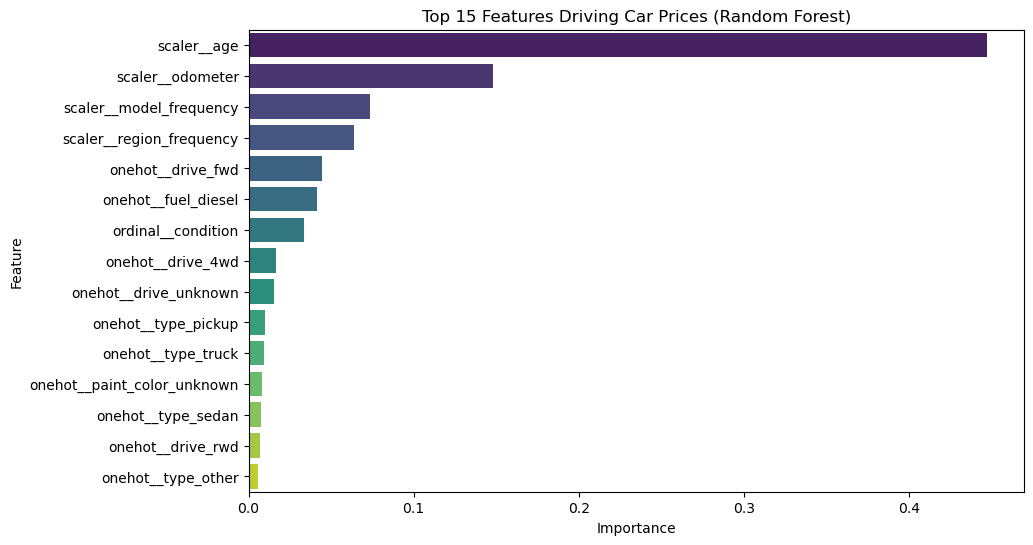

In [83]:
plt.figure(figsize=(10, 6))
sns.barplot(data=important_features_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Features Driving Car Prices (Random Forest)')
plt.show()

****Interpretation:**** Based on the above dataframe and plot, the most important feature is the age of the car, indicating that the year of manufacture has a significant impact on the car's price. This is likely due to depreciation over time. The second most important feature is the odometer value, which also makes sense as cars with higher mileage tend to be less valuable.

The model of the car is the third most important feature, indicating the popular models are in more demand causing the price to increase. The region of the car is also important, this indicates the car prices vary across the country.

The `drive` train of the car is also important showing that `FWD` is more important than `4wd` or `RWD`.


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

### Summary for Dealers

To maximize profit and accuracy in pricing, dealers must prioritize:
- **Age of the Car**: Older cars depreciate faster, so dealers should consider this when setting prices.
- **Odometer Value**: Higher mileage reduces value, so dealers should adjust prices accordingly.
- **Model Popularity**: Dealers should stock popular models to capitalize on demand.
- **Regional Pricing**: Prices vary by region, so dealers should consider local market conditions.
- **Drive Train**: The drive system is a top 5 price impact so is a strong predictor for price, and dealers should pay close attention to local demand for `4WD` vs `FWD`.
- **Vehicle Type**: The type of vehicle (sedan, SUV, etc.) can significantly impact pricing, so dealers should consider this when setting prices.
- **Fuel Type**: Diesel vehicles are generally more expensive than gasoline vehicles, so dealers should adjust prices accordingly.
